# Como dibujar un grafico de volcanes con ggplot2
Kevin Pumayalli
2024-08-19

- [Introduccion](#Introduccion)
- [Importar un dataset de prueba](#Importar-un-dataset-de-prueba)
- [Dibujar un gráfico de volcanes básico](#Dibujar-un-grafico-de-volcanes-basico)
- [Agregar líneas horizontales y verticales](#Agregar-lineas-horizontales-y-verticales)
- [Modificar el eje x y el eje y](#Modificar-el-eje-x-y-el-eje-y)
- [Agregar color, tamaño y transparencia a los puntos](#Agregar-color,-tamaño-y-transparencia-a-los-puntos)
- [Agregar una nueva subtrama en capas](#Agregar-una-nueva-subtrama-en-capas)
- [Etiquetar puntos de interés](#Etiquetar-puntos-de-interés)
- [Modificar las posiciones de las etiquetas de leyenda](#Modificar-las-posiciones-de-las-etiquetas-de-leyenda)
- [Modificar las etiquetas y el tema de los gráficos](#Modificar-las-etiquetas-y-el-tema-de-la-gráfica)
- [Anotar texto](#Anotar-texto)
- [Otros recursos](#Otros-recursos)

In [3]:
# Cargando los paquetes necesarios
if(!require("pacman")) install.packages("pacman")
pacman::p_load(here,  
               tidyverse, 
               janitor, # Limpiar los nombres de las columnas
               scales, # Transformar las escalas de los ejes   
               ggrepel) # Optimizar la separacion de las etiquetas de los graficos  

Loading required package: pacman



# Introduccion
[Los graficos de volcanes](https://en.wikipedia.org/wiki/Volcano_plot_(statistics))
son un concepto oscuro fuera de la bioinformatica, pero su construccion se puede
utilizar para demostrar la elegancia y versatilidad de `ggplot2`.

Desde el año 2020, se han agregado varias funciones nuevas y utiles a `dplyr` y 
`ggplot2`, que se han actualizado para reflejar en esta publicacion. Este codigo
asi como la logica de la codificacion fue inspirado por [Chuanxin Liu](https://github.com/codetrainee). Tambien se puede ver los [tutoriales de ggplot2 de Rstudio Cloud](https://rstudio.cloud/learn/primers/3), en los que aparecen funciones nuevas de `ggplot`.

Comencemos.


# Importar un dataset de prueba
Los datos utilizados en este tutorial provienen de [aqui](https://zenodo.org/records/2529117#.X-_obzTis2w). Y se almacena en la nube en la cual se encuentra este proyecto `.../cloud/project/`.

Los datos contienen 5 columnas de interes:

- **Entrez ID** : Almacena el ID de un gen unico.
- **Gene symbol** : Almacena el simbolo de gen asociado con un Entrez ID unico.
- **Gene name** : Almacena el nombre de gen asociado con un Entrez ID unico.
- **log2(Fold change)** : Almacena el cambio transformado en log2 en el nivel de expresion genica entre 2 tipos de muestra de tejido.
- **Adjusted p-value** : Almacena el valor p ajustado con una correcion de tasa de descubrimiento falso (FDR) para pruebas multiples.

Cada fila muestra valores para un gen unico, lo que cumple con los requisitos de datos ordenados para crear visualizaciones de datos.

In [4]:
# Cargando el dataset
muestras <- read_delim(here("/kaggle/input/datosvolcano", "/luminal_pregnant-lactate.txt"), 
                       delim = "\t") # Las columnas estan separadas por una tabulacion

# Limpiando los nombres de las columnas
# Primero convertimos los nombres de las columnas que estan en mayusculas y en cascada a 
# un formato mas legible, es decir todo a minusculas
muestras <- clean_names(muestras)

# Luego editamos manualmente los nombres de las columnas usando la funcion rename()
muestras <- muestras %>% rename(entrez_id = entrezid,
                                gene_name =genename)

# Finalmente, visualizamos el conjunto de datos como una tabla
muestras %>%  head(5) %>% knitr::kable()

Rows: 15804 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): SYMBOL, GENENAME
dbl (6): ENTREZID, logFC, AveExpr, t, P.Value, adj.P.Val

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.




| entrez_id|symbol  |gene_name                                                                       |    log_fc| ave_expr|         t| p_value| adj_p_val|
|---------:|:-------|:-------------------------------------------------------------------------------|---------:|--------:|---------:|-------:|---------:|
|     12992|Csn1s2b |casein alpha s2-like B                                                          | -8.603611| 3.562950| -43.79650|       0|         0|
|     13358|Slc25a1 |solute carrier family 25 (mitochondrial carrier, citrate transporter), member 1 | -4.124175| 5.779699| -29.90785|       0|         0|
|     11941|Atp2b2  |ATPase, Ca++ transporting, plasma membrane 2                                    | -7.386986| 1.282143| -27.81950|       0|         0|
|     20531|Slc34a2 |solute carrier family 34 (sodium phosphate), member 2                           | -4.177812| 4.278629| -27.07272|       0|         0|
|    100705|Acacb   |acetyl-Coenzyme A carboxylase beta             

# Dibujar un grafico de volcanes basico
Un grafico de volcan muestra:

- A lo largo de su eje x : `log_fc`, es decir, el cambio de pliegue transformado en log2.
- A lo largo de su eje y : `-log10(adj_p_val)`, es decir, el valor p ajustado transformado en -log10.

Nota: La transformacion `-log10(adj_p_val)` permite que los puntos del grafico se proyecten hacia arriba a medida que el cambio de pliegue aumenta o disminuye en magnitud.

El valor de p ajustado disminuye de manera no lineal a medida que el cambio de pliegue aumenta o disminuye en magnitud. Visualizar valores `adj_p_val` decrecientes en una direccion positiva a lo largo del eje y es mas intuitivo, ya que lo que mas le interesa es identificar genes que tienen un gran cambio de pliegue y un pequeño valor p ajustado.

Podemos aplicar transformaciones directamente dentro de `ggplot(data, aes(x, y))`

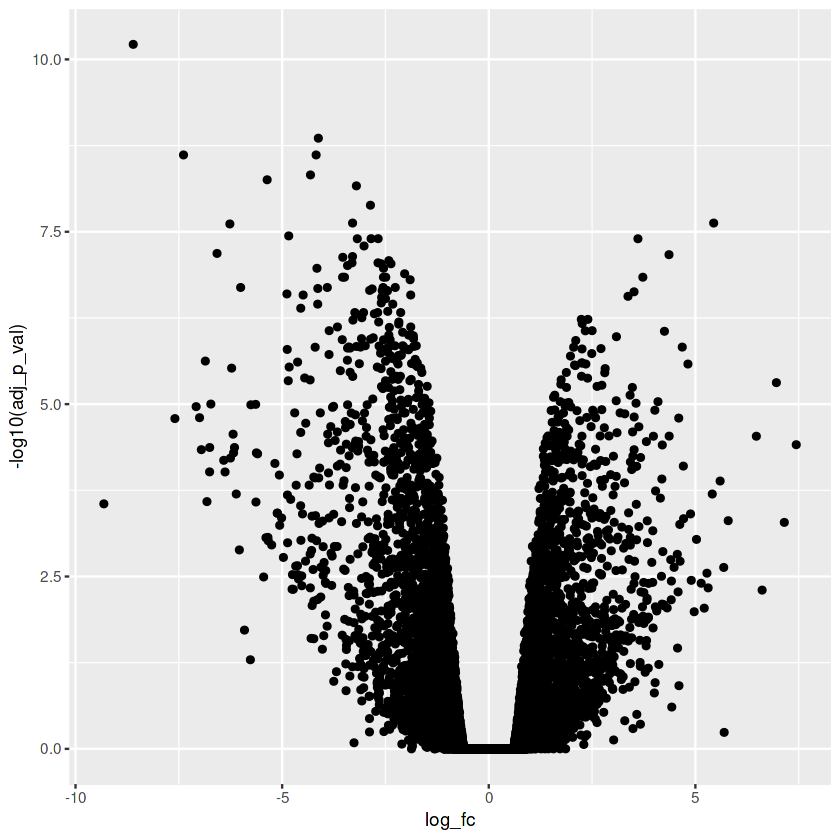

In [5]:
# Creamos un grafico basico de volcanes
volcan_plot <- muestras %>% ggplot(mapping = aes(x = log_fc, y = -log10(adj_p_val))) + 
geom_point()

volcan_plot # Aqui visualizamos la salida del ggplot

Alternativamente, podemos visualizar los valores originales a lo largo de un eje transformado utilizando `scale_x_continuous(trans = " ")` o `coord_trans(x, y)` para transformar el eje en si.

[1] 1e-11 1e-09 1e-07 1e-05 1e-03 1e-01

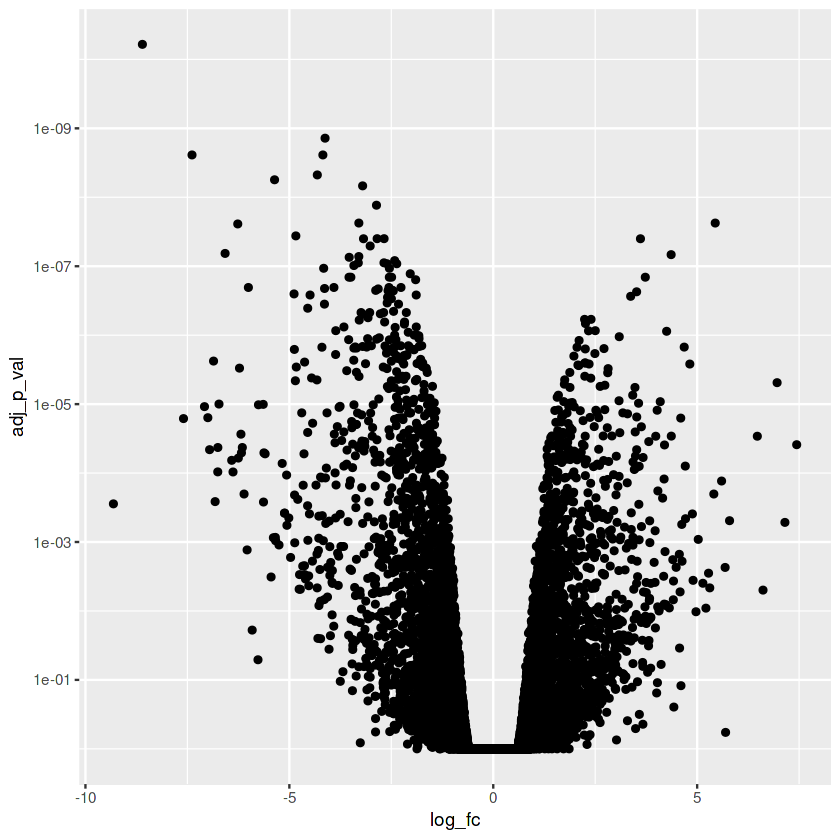

In [6]:
# Metodo avanzado para transformar el eje y en lugar de los valores y
neg_log10_trans <- trans_new(name = "neg log10", 
                             transform = function(x) -log10(x),
                             inverse = function(x) 10 ^ (-1 * x),
                             breaks = breaks_log(n = 6, base = 10))
# Verificamos los breaks() generados automaticamente
breaks_log(n = 6, base= 10)(muestras$adj_p_val)

muestras %>% ggplot(aes(x = log_fc, y = adj_p_val)) + geom_point() + 
scale_y_continuous(trans = neg_log10_trans)

# Agregar lineas horizontales y verticales
Las funciones `geom_hline()` y `geom_vline()` se puede utilizar para agregar lineas horizontales y verticales adicionales en su grafico respectivamente. En este caso, lo que haremos sera visualizar los limites de los genes que tienen un valor p_adj <= 0,05 y log_fc <= -1 o log_fc >= 1.

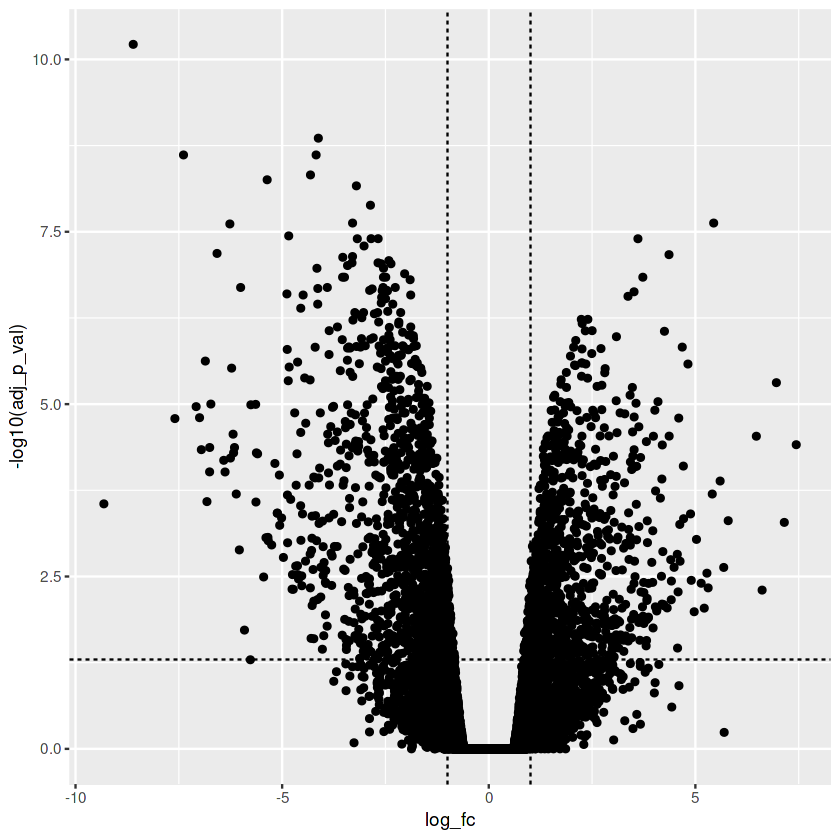

In [7]:
# Trazamos los cuadrantes adicionales
volcan_plot + geom_hline(yintercept = -log10(0.05), linetype = "dashed") + 
geom_vline(xintercept = c(log2(0.5), log2(2)), linetype = "dashed")

# Modificar el eje x y el eje y
Los graficos de volcanes deben tener un eje x simetrico. Una forma de hacer esto es estableciendo manualmente los limites del eje x usando `xlim(min, max)`

[1] -10

[1] 8

[1] 10

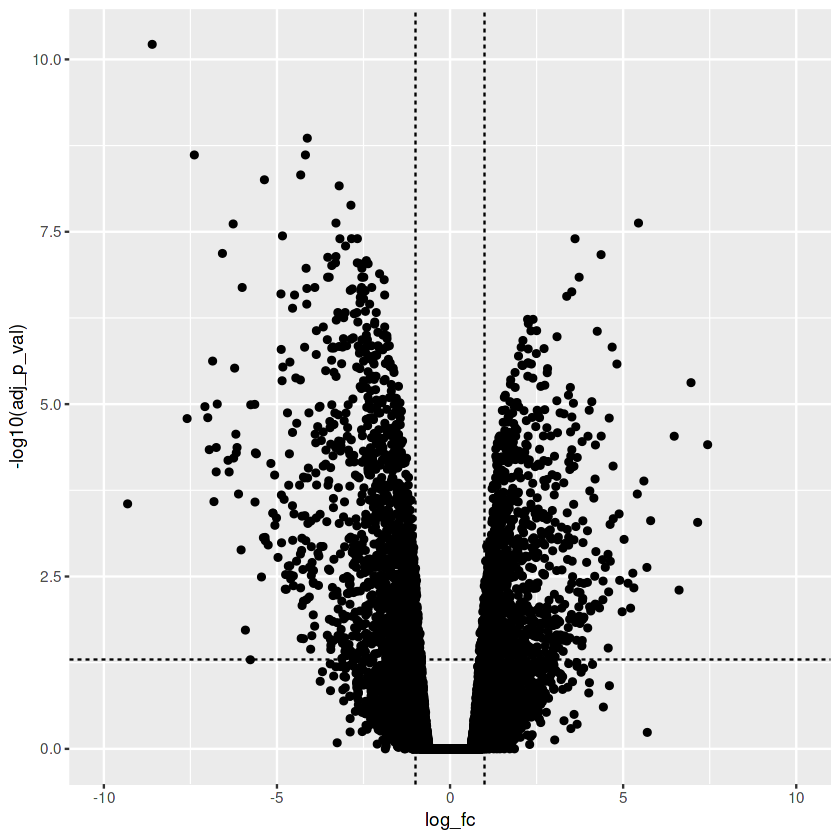

In [8]:
# Identificando el mejor rango minimo para xlim()
muestras %>% select(log_fc) %>% min() %>% floor()

# Luego identificamos el mejor rango maximo para xlim()
muestras %>% select(log_fc) %>% max() %>% ceiling()

# Ahora entre estos 2 valores, hallamos el maximo absoluto
c(-10, 8) %>% abs() %>% max()

# Ahora que ya tenemos el rango minimo para la simetria, modificamos el xlim()
# Especificamos manualmente los limites del eje x
volcan_plot + 
geom_hline(yintercept = -log10(0.05), linetype = "dashed") + 
geom_vline(xintercept = c(log2(0.5), log2(2)), linetype = "dashed") + 
xlim(-10, 10)

Tambien se puede cambiar los limites del eje x mediante `scale_x_continuous`. Este metodo tambien le brinda la flexibilidad de ajustar con precision el espaciado y el etiquetado de las marcas de graduacion del eje.

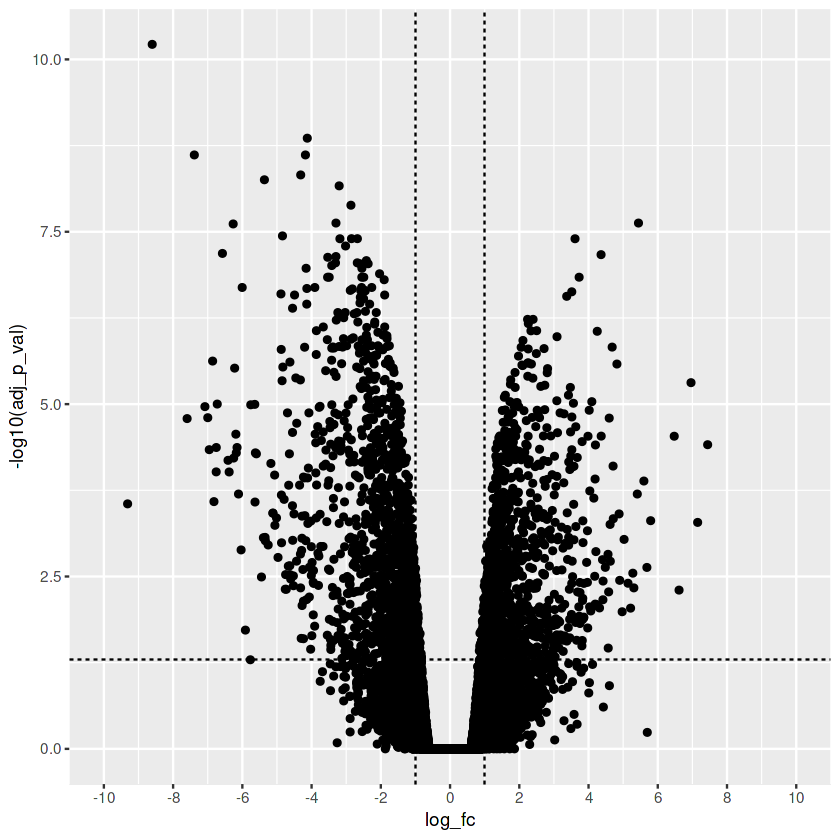

In [9]:
# Modificando con scale_x_continuous()
volcan_plot +
geom_hline(yintercept = -log10(0.05), linetype = "dashed") +
geom_vline(xintercept = c(log2(0.5), log2(2)), linetype = "dashed") +
scale_x_continuous(breaks = c(seq(-10, 10, 2)), # Aqui podemos modificar los intervalos
                  limits = c(-10, 10)) # Modificar el rango de xlim()

**Nota**: El valor especificado dentro del argumento `scale_x_continuous(limits = ...) ` reemplaza el rango de valores especificado dentro del argumento `scale_x_continuous(breaks = ...)`

# Agregar color, tamaño y transparencia a los puntos
Para visualizar diferentes grupos de genes utilizando diferentes colores, tamaños de puntos, formas o transparencias, debe clasificar los genes en diferentes grupos y almacenar estas categorias como un nuevo parametro, es decir, una nueva columna de datos.

Por ejemplo, me interesa etiquetar los genes en los siguientes 3 grupos :
- Genes con `log_fc >= 1` y `adj_p_val <= 0.05` como `ascendentes`
- Genes con `log_fc <= -1` y `adj_p_val <= 0.05` como `descendentes`
- Todos los demas genes etiquetados como `ns`, es decir, no significativos.

In [10]:
# Crear una nueva columna categorica
muestras <- muestras %>% 
    mutate(tipo_gen = case_when(log_fc >= 1 & adj_p_val <= 0.05 ~ "ascendente", 
                                log_fc <= -1 & adj_p_val <= 0.05 ~ "descendente",
                                TRUE ~ "ns"))

# Contar las categorias de tipo_gen
muestras %>% count(tipo_gen) %>% knitr::kable()

# La funcion count() es equivalente a agrupar y usar el summarize
muestras %>% group_by(tipo_gen) %>% summarize(count = n())



|tipo_gen    |     n|
|:-----------|-----:|
|ascendente  |   981|
|descendente |  1245|
|ns          | 13578|

tipo_gen,count
<chr>,<int>
ascendente,981
descendente,1245
ns,13578


En `ggplot2`, tambien tenemos la opcion de visualizar diferentes grupos por color de punto, tamaño, forma y transparencia modificando unicamente los parametros a traves de `scale_color_manual()`, etc. Una forma ordenada de hacer esto es almacenar cada especificacion visual en un vector separado

[1] "descendente" "ascendente"  "ns"

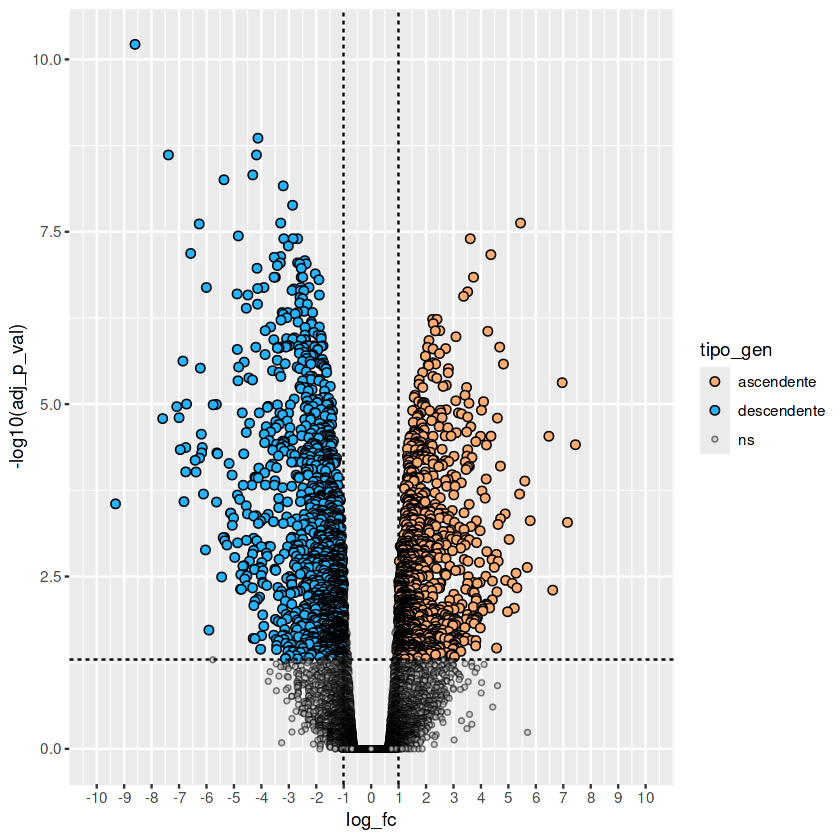

In [11]:
# Verificamos los nombres de las categorias de la columna tipo_gen
muestras %>% distinct(tipo_gen) %>% pull()

# Establenciendo el color, tamaño y transparencia (alpha) al grafico de volcanes
colores <- c("ascendente" = "#ffad73", "descendente" = "#26b3ff", "ns" = "grey")
tamaños <- c("ascendente" = 2, "descendente" = 2, "ns" = 1)
alphas <- c("ascendente" = 1, "descendente" = 1, "ns" = 0.5)

# Agregando las caracteristicas al grafico
muestras %>%
    ggplot(mapping = aes(x = log_fc, 
                         y = -log10(adj_p_val), 
                         fill = tipo_gen, 
                         size = tipo_gen,
                         alpha = tipo_gen)) +
    geom_point(shape = 21, # Especifica la forma y el color como parametros locales fijos
              colour = "black") +
    geom_hline(yintercept = -log10(0.05), linetype = "dashed") +
    geom_vline(xintercept = c(log2(0.5), log2(2)), linetype = "dashed") +
    scale_fill_manual(values = colores) + # Modifica el color del punto
    scale_size_manual(values = tamaños) + # Modifica el tamaño del punto
    scale_alpha_manual(values = alphas) + # Modifica la transparencia del punto
    scale_x_continuous(breaks = c(seq(-10, 10, 1)),
                      limits = c(-10, 10))

# Agregar una nueva subtrama en capas
Tambien podemos superponer subtramas sobre la trama principal. Esto resulta util cuando deseamos resaltar un subconjunto de nuestros datos utilizando diferentes colores, formas, etc. Al superponer tramas, no debemos utilizar barras verticales `%>%`, sino utilizar argumentos globales `ggplot(data = "...")` y locales `geom_point(data = ...)` en su lugar.

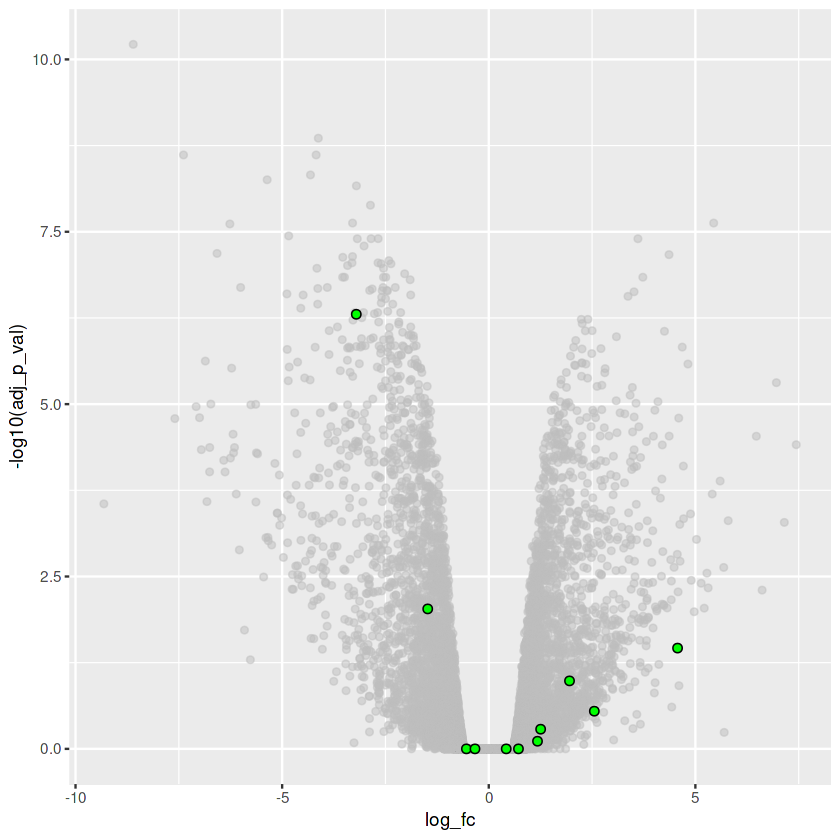

In [12]:
# Definimos un subconjunto que sera de interes, a partir de los datos originales
sdi <- str_subset(muestras$symbol, "^[I|i]l[0-9]+$")

il_genes <- muestras %>% filter(symbol %in% sdi)

# Agregamos una capa de un subgrafico al grafico principal del volcan
ggplot(data = muestras, # Datos originales
      mapping = aes(x = log_fc, y = -log10(adj_p_val))) +
geom_point(colour = "grey", alpha = 0.5) +
geom_point(data = il_genes, # Nueva capa que contiene el subconjunto de datos il_genes
           size = 2,
           shape = 21,
           fill = "green",
           colour = "black")

**Nota:** A menos que se especifique la estetica local, las funciones secundarias `geom_point()` heredaran la estetica global de `ggplot()`

# Etiquetar puntos de interés
Tambien podemos etiquetar un subconjunto de datos utilizando `geom_text()`, `geom_label()`, `geom_text_repel()` o `geom_label_repel()` y especificando que columna se mostrara como texto utilizando el argumento local `geom_text(aes(label = ...))`.

**Nota:** Ajustar los parametros para lograr una separacion optima del texto con `geom_text_repel()` puede ser un poco complicado. Generalmente, comienzo modificando la fuerza y luego decidiendo hacia que region del grafico quiero desplazar el texto o las etiquetas. 

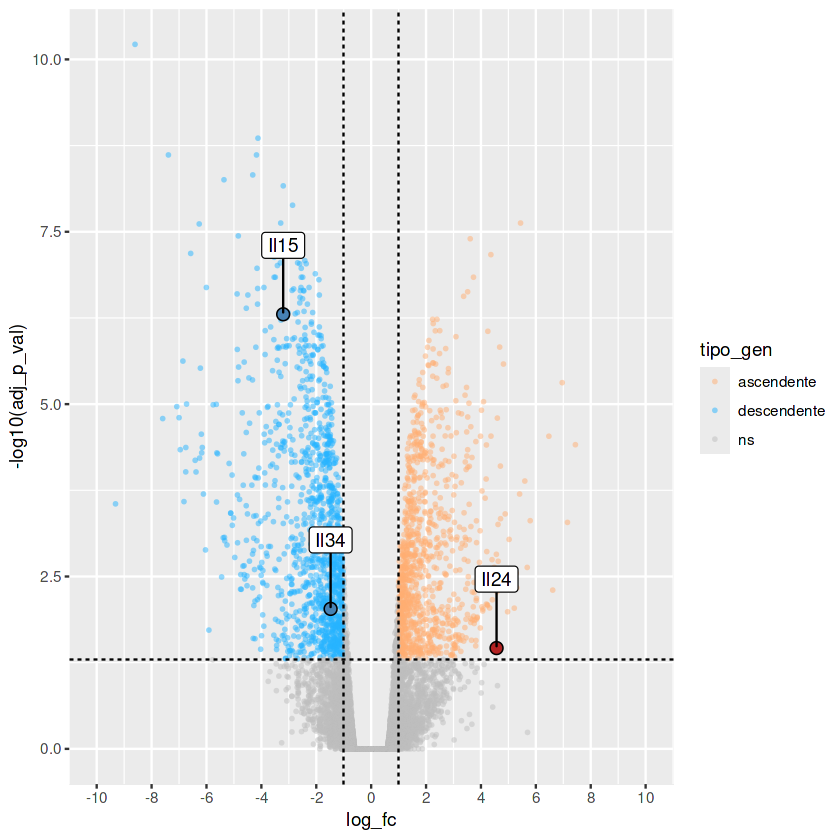

In [35]:
# Definimos otro subconjunto de interes a partir de los datos originales
sig_il_genes <- muestras %>% filter(symbol %in% c("Il15", "Il34", "Il24"))

asc_il_genes <- muestras %>% filter(symbol == "Il24")

desc_il_genes <- muestras %>% filter(symbol %in% c("Il15", "Il34"))

# Agrega otra capa de subgraficos y etiquetas a la grafica principal del volcan
ggplot(data = muestras, mapping = aes(x = log_fc, y = -log10(adj_p_val))) +
geom_point(mapping = aes(colour = tipo_gen), alpha = 0.5, shape = 16, size = 1) +
geom_point(data = asc_il_genes, shape = 21, size = 3, fill = "firebrick", colour = "black") +
geom_point(data = desc_il_genes, shape = 21, size = 3, fill = "steelblue", colour = "black") +
geom_hline(yintercept = -log10(0.05), linetype = "dashed") +
geom_vline(xintercept = c(log2(0.5), log2(2)), linetype = "dashed") + 
geom_label_repel(data = sig_il_genes, # Agregamos las etiquetas al final como capa superior 
                 aes(label = symbol), force = 2, nudge_y = 1) +
scale_colour_manual(values = colores) + 
scale_x_continuous(breaks = c(seq(-10, 10, 2)),
                  limits = c(-10, 10))

# Modificar las posiciones de las etiquetas de leyenda
Si necesita cambiar el orden de los valores de la leyenda de las figuras categoricas, debera usar `factor()` y volver a nivelar su variable categorica. Esto se puede hacer utilizando el paquete `forcats`, que le permite modificar facilmente los niveles de los factores.

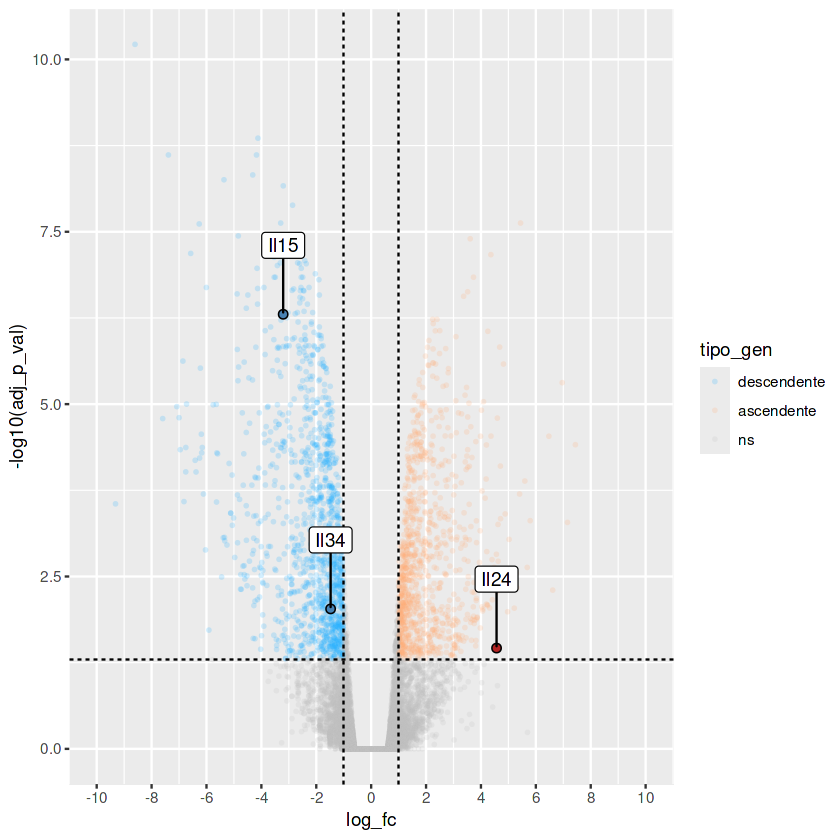

In [58]:
# Modificar las etiquetas de la leyenda reordenando los niveles de tipo_gen
muestras <- muestras %>% mutate(tipo_gen = fct_relevel(tipo_gen, "descendente", "ascendente"))

ggplot(data = muestras, aes(x = log_fc, y = -log10(adj_p_val))) + 
geom_point(aes(colour = tipo_gen), alpha = 0.2, shape = 16, size = 1) + 
geom_point(data = asc_il_genes, shape = 21, size = 2, fill = "firebrick", colour = "black") +
geom_point(data = desc_il_genes, shape = 21, size = 2, fill = "steelblue", colour = "black") +
geom_hline(yintercept = -log10(0.05), linetype = "dashed") +
geom_vline(xintercept = c(log2(0.5), log2(2)), linetype = "dashed") + 
geom_label_repel(data = sig_il_genes, aes(label = symbol), force = 2, nudge_y = 1) +
scale_colour_manual(values = colores) +
scale_x_continuous(breaks = c(seq(-10, 10, 2)), limits = c(-10, 10))

# Modificar las etiquetas y el tema de la gráfica
Los toques finales incluyen la modificacion de las etiquetas y el tema de la grafica.

La funcion `labs()` es una forma practica de organizar todas las etiquetas de la grafica dentro de una unica funcion. Puede asignar etiquetas como `NULL` para evitar que se muestren.

Se puede mejorar aun mas una grafica cambiando su `theme()` y/o modificando parametros individuales de `theme()`.

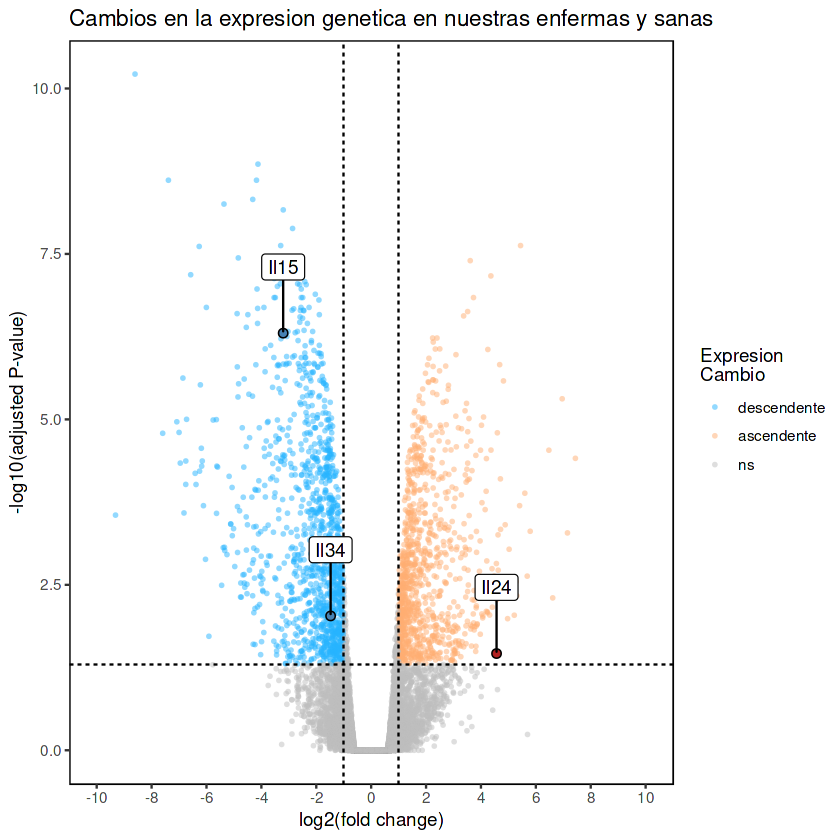

In [90]:
# Agregar etiquetas de grafico y modificar el tema del grafico
grafico_final <- ggplot(data = muestras, mapping = aes(x = log_fc, y = -log10(adj_p_val))) +
geom_point(mapping = aes(colour = tipo_gen), alpha = 0.5, shape = 16, size = 1) +
geom_point(data = asc_il_genes, shape = 21, size = 2, fill = "firebrick", colour = "black") +
geom_point(data = desc_il_genes, shape = 21, size = 2, fill = "steelblue", colour = "black") +
geom_hline(yintercept = -log10(0.05), linetype = "dashed") +
geom_vline(xintercept = c(log2(0.5), log2(2)), linetype = "dashed") +
geom_label_repel(data = sig_il_genes, aes(label = symbol), force = 2, nudge_y = 1) +
scale_colour_manual(values = colores) +
scale_x_continuous(breaks = c(seq(-10, 10, 2)), limits = c(-10, 10)) +
labs(title = "Cambios en la expresion genetica en nuestras enfermas y sanas", 
     x = "log2(fold change)",
     y = "-log10(adjusted P-value)",
     colour = "Expresion \nCambio") +
theme_bw() + # Seleccionamos tema con fondo blanco
theme(panel.border = element_rect(colour = "black", fill = NA, size = 0.5),
     panel.grid.minor = element_blank(),
     panel.grid.major = element_blank())

grafico_final

**Nota:** Tambien podemos especificar `panel.grid... = element_line(linetype = "dotted")` dentro de `theme()` para crear lineas de cuadricula punteadas a lo largo del eje x y/o y. Las posiciones principales de las lineas de cuadricula se heredan de los valores de los cortes de eje.

# Anotar texto
Podemos agregar mas descripciones a un grafico utilizando la funcion `annotate()` para mostrar texto en el grafico.

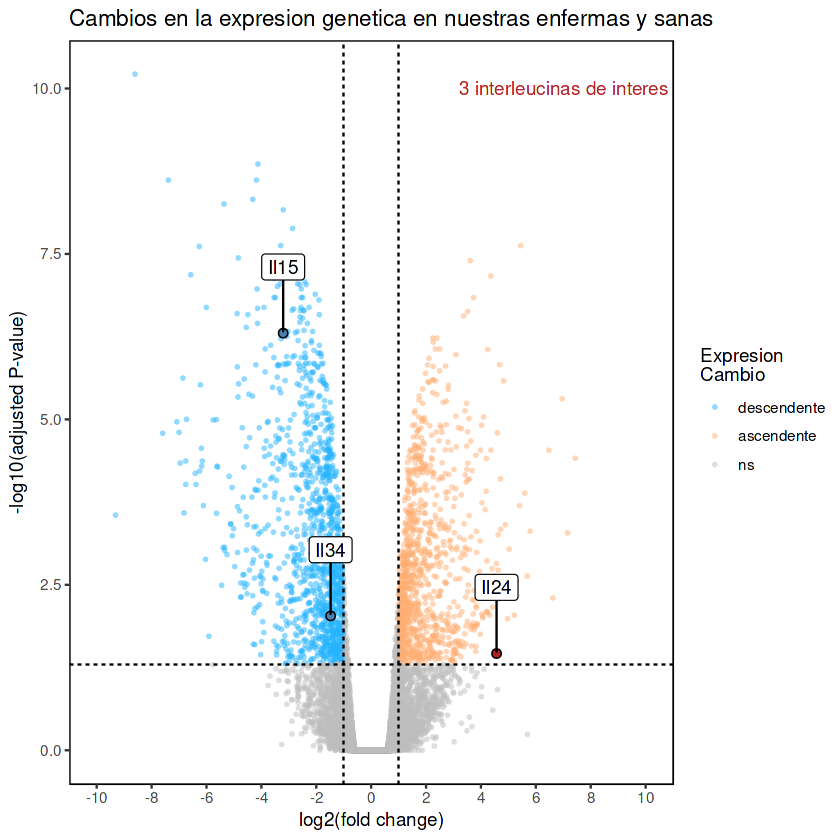

In [92]:
# Anotar texto dentro del grafico
grafico_final + annotate("text", 
                         x = 7, 
                         y = 10, 
                         label = "3 interleucinas de interes", 
                         color = "firebrick")

# Otros recursos
* Las excelentes e interactivos [tutoriales de ggplot2 de Rstudio Cloud](https://posit.cloud/learn/recipes).
* La [hoja de trucos](https://github.com/rstudio/cheatsheets/blob/main/data-visualization-2.1.pdf) de `ggplot2` de Rstudio.